<a href="https://colab.research.google.com/github/sargyri/Drop_Lev/blob/master/Volume_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Lev Droplet 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

NN for predicting volume and voltage from the coordinate in polar system

In [ ]:
# Use seaborn for pairplot
!pip install seaborn
#!pip install talos

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pprint
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Instructions for updating:
non-resource variables are not supported in the long term
2.3.0


Run the next code box only if google drive is not mounted to colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


If it **is** mounted continue from here on

In [3]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

TPU address is grpc://10.33.112.138:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 7356725167691526736),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, -3664299002491481450),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1653881564591155150),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1631980260023647450),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, -988743405773692751),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 558069678448489003),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, -2951902731977985514),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, -3388467178250990230),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, -716144411097

### Get the data
First download the dataset!

**Option 1**: Upload files

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import io
csvfilename=str('TritonX100_conci_0.0100_all.csv')
input = pd.read_csv(io.BytesIO(uploaded[csvfilename]))
#input = pd.read_csv(csvfilename, sep="\t")
# Dataset is now stored in a Pandas Dataframe
input.shape

**Option 2**: Import files from drive

In [91]:
#From the drive folder that is mounted to collab go to the file that you are interested in, 
#right click and copy the path of the file. Paste it in csvfilename:
import numpy as np
file1=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.00500_ML_data.csv'), sep="\t")
file2=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.25000_ML_data.csv'), sep="\t")
file3=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_0.40000_ML_data.csv'), sep="\t")
file4=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/CTAB_conci_13.15224_ML_data.csv'), sep="\t")
#file5=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_6.50000_ML_data.csv'), sep="\t")
#file6=pd.read_csv(str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_24.75900_ML_data.csv'), sep="\t")

input=np.vstack([file1, file2, file3, file4]) #, file5, file6])

#csvfilename=str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_1.50000_ML_data.csv')

#input = pd.read_csv(csvfilename)


In [92]:
input.shape

(20199, 606)

Import it using pandas

In [105]:
column_names=[]

for i in range(300):
  column_names.append('rho_%d' %i)
#for i in range(300):
#  column_names.append('phi_%d' %i)
for i in range(300):
  column_names.append('theta_%d' %i)
#column_names.append('height')
#column_names.append('width')  
column_names.append('volume')
#column_names.append('R_sph')
column_names.append('volt')
#column_names.append('Intensity')
#column_names.append('time')
#column_names.append('TritonX_conc')
#column_names.append('Ar')
#column_names.append('Ps')
#column_names.append('Ps_err')
column_names.append('centre_x')
column_names.append('centre_y')
column_names.append('Aspect_Ratio')
column_names.append('st')

#raw_dataset = pd.read_csv(csvfilename, sep="\t")
#raw_dataset.columns=column_names

raw_dataset = pd.DataFrame(data=input,  columns=column_names) 
              
raw_dataset.shape

dataset = raw_dataset.copy()

dataset.pop("centre_x")
dataset.pop("centre_y")
dataset.pop('volt')
dataset.pop('st')
#dataset.pop('Ps')
#dataset.pop('Ps_err')
#dataset.pop('TritonX_conc')
#dataset.pop("volume")
#dataset.pop("height")
#dataset.pop("width")
#dataset.pop("R_sph")
dataset.pop("Aspect_Ratio")

dataset.tail()

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19,rho_20,rho_21,rho_22,rho_23,rho_24,rho_25,rho_26,rho_27,rho_28,rho_29,rho_30,rho_31,rho_32,rho_33,rho_34,rho_35,rho_36,rho_37,rho_38,rho_39,...,theta_261,theta_262,theta_263,theta_264,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume
20194,0.012755,0.012631,0.012852,0.012664,0.012728,0.012650,0.012572,0.012494,0.012982,0.013046,0.012481,0.012357,0.013065,0.012376,0.013117,0.012330,0.012193,0.013252,0.012167,0.012121,0.012153,0.012094,0.012049,0.012081,0.013406,0.011963,0.011950,0.013527,0.011936,0.013546,0.011877,0.011910,0.011864,0.011851,0.011765,0.013661,0.013680,0.013699,0.013718,0.013737,...,3.968358,3.968290,3.968037,3.967565,3.965982,3.965305,3.964852,3.964630,3.963871,3.963801,3.963140,3.962825,3.962330,3.961784,3.961719,3.960934,3.960876,3.960623,3.960560,3.960114,3.959598,3.957452,3.957396,3.957180,3.957128,3.956445,3.956394,3.956286,3.956180,3.955854,3.955754,3.955152,3.955054,3.954886,3.954836,3.954786,3.954638,3.954588,3.954345,1.098164
20195,0.012545,0.012655,0.012843,0.012499,0.012876,0.012531,0.012563,0.012752,0.012895,0.012817,0.012472,0.012394,0.012959,0.012381,0.012303,0.012257,0.012276,0.013140,0.012152,0.013094,0.012066,0.012020,0.011994,0.013332,0.011980,0.011849,0.013440,0.011835,0.011868,0.011809,0.011763,0.011750,0.011782,0.013548,0.013567,0.013586,0.013605,0.011670,0.011624,0.011597,...,3.971811,3.971193,3.971108,3.969572,3.969111,3.968041,3.967959,3.966632,3.966566,3.965908,3.965834,3.965760,3.964780,3.964388,3.964325,3.963732,3.963663,3.963570,3.962556,3.961589,3.961524,3.960686,3.960628,3.959965,3.959908,3.959357,3.959297,3.959294,3.958615,3.958504,3.958173,3.958059,3.957927,3.957818,3.957612,3.957557,3.957502,3.957339,3.957285,1.097919
20196,0.012469,0.012690,0.012534,0.012377,0.012566,0.012832,0.012676,0.012865,0.012787,0.012442,0.012819,0.012273,0.012916,0.012967,0.012154,0.012141,0.012063,0.012095,0.012049,0.012036,0.013167,0.011990,0.012023,0.011977,0.011845,0.011832,0.011773,0.011805,0.011760,0.011719,0.011693,0.013472,0.013524,0.011666,0.011620,0.011594,0.013581,0.013600,0.011567,0.011508,...,3.969436,3.969355,3.969124,3.969054,3.968353,3.968317,3.968274,3.967199,3.966834,3.966205,3.966020,3.965335,3.965068,3.964995,3.964011,3.963884,3.963821,3.962412,3.961784,3.961719,3.961639,3.961579,3.960137,3.959659,3.959537,3.958838,3.958782,3.958670,3.958615,3.958173,3.958147,3.958116,3.958059,3.957557,3.957447,3.957285,3.957009,3.956955,3.956739,1.098068
20197,0.012710,0.012521,0.012508,0.012807,0.012618,0.012430,0.012352,0.012839,0.012462,0.012494,0.012793,0.012338,0.012923,0.012233,0.013052,0.013006,0.012220,0.012024,0.013257,0.011984,0.011938,0.013295,0.011957,0.011911,0.011826,0.013404,0.011812,0.011767,0.011799,0.011740,0.011727,0.013512,0.011714,0.013531,0.013550,0.011628,0.013627,0.011588,0.011575,0.011529,...,3.966814,3.965806,3.965731,3.964883,3.964654,3.963323,3.962587,3.961870,3.961811,3.960535,3.960471,3.959569,3.959514,3.959484,3.959422,3.958740,3.958379,3.958320,3.957227,3.956255,3.956200,3.955754,3.955704,3.955005,3.954956,3.954297,3.954062,3.954011,3.953580,3.953486,3.952911,3.952855,3.952815,3.952763,3.952440,3.952394,3.952348,3.952211,3.952165,1.094999
20198,0.012626,0.012658,0.012470,0.012314,0.012723,0.012534,0.012346,0.012645,0.012755,0.012567,0.012489,0.012365,0.012852,0.012241,0.012150,0.012182,0.012104,0.012136,0.012923,0.012058,0.012955,0.012987,0.012077,0.012032,0.013071,0.013122,0.011927,0.011914,0.011854,0.011887,0.011841,0.013263,0.011742,0.011683,0.011643,0.013428,0.011472,0.013562,0.013581,0.011392,...,3.966263,3.965757,3.965692,3.965011,3.

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [106]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

In [ ]:
#sns.pairplot(train_dataset[column_names], diag_kind="kde")
#plt.show()

In [107]:
train_stats = train_dataset.describe()
train_stats.pop('volume')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
rho_0,16159.0,0.012974,0.000317,0.012084,0.012754,0.012964,0.013168,0.014676
rho_1,16159.0,0.012972,0.000327,0.011826,0.012747,0.012960,0.013177,0.014991
rho_2,16159.0,0.012974,0.000334,0.012070,0.012740,0.012956,0.013187,0.014833
rho_3,16159.0,0.012974,0.000341,0.011812,0.012737,0.012957,0.013195,0.014708
rho_4,16159.0,0.012976,0.000347,0.012010,0.012734,0.012958,0.013198,0.014945
...,...,...,...,...,...,...,...,...
theta_295,16159.0,3.866789,0.035951,3.767795,3.839945,3.864627,3.892343,3.970596
theta_296,16159.0,3.866622,0.035930,3.767738,3.839817,3.864516,3.892239,3.970519
theta_297,16159.0,3.866457,0.035906,3.767540,3.839617,3.864355,3.892084,3.970060
theta_298,16159.0,3.866283,0.035890,3.767384,3.839449,3.864246,3.891849,3.969909


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [108]:
train_labels = train_dataset.pop('volume')
test_labels = test_dataset.pop('volume')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [109]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
#normed_train_data = train_dataset
#normed_test_data = test_dataset


This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [98]:
def build_model():
  model = keras.Sequential([
    #layers.Dense(800, activation=tf.nn.sigmoid, input_shape=[len(train_dataset.keys())]),
    #layers.Dense(200, activation=tf.nn.sigmoid),
    layers.Dense(20, activation=tf.nn.sigmoid, input_shape=[len(train_dataset.keys())]),
    layers.Dense(1)
  ])

  #optimizer = tf.keras.optimizers.RMSprop(0.0000001)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.0001)
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
  #optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.8, beta_2=0.995)

  #model.compile(loss='mean_squared_error',
  #              optimizer=optimizer,
  #              metrics=['mean_absolute_error', 'mean_squared_error'])
  
  model.compile(loss='mean_absolute_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  
  
  return model

In [99]:
model = build_model()

## If there is a model saved on google drive execute the next block

In [110]:
from tensorflow.keras.models import load_model

del model 

model_name=str('SDS_volume_pred_trial_4.h5')
model = load_model(str("/content/drive/My Drive/DropLev/MachineLearningModels/"+model_name))


### Inspect the model

Use the `.summary` method to print a simple description of the model

In [111]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                12020     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 12,041
Trainable params: 12,041
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [112]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[3.9475756],
       [1.383054 ],
       [3.908187 ],
       [3.5878735],
       [4.9004183],
       [2.2600932],
       [2.0207775],
       [3.9454408],
       [1.9130672],
       [4.9236174]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [113]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 55 == 0: print('')
    print('.', end='')


EPOCHS = 700


early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5, verbose=0, mode='auto')


history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])  # callbacks=callbacks_list


...........................

Visualize the model's training progress using the stats stored in the `history` object.

In [114]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
22,0.035944,0.035944,0.002326,0.047203,0.047203,0.003737,22
23,0.037676,0.037676,0.002582,0.046305,0.046305,0.003651,23
24,0.036068,0.036068,0.002365,0.043657,0.043657,0.003254,24
25,0.035634,0.035634,0.002294,0.045138,0.045138,0.003633,25
26,0.037242,0.037242,0.002501,0.041137,0.041137,0.003029,26


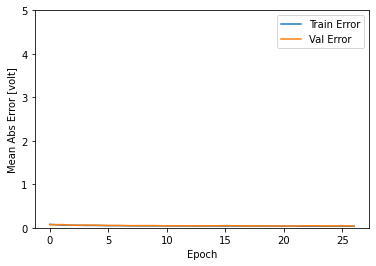

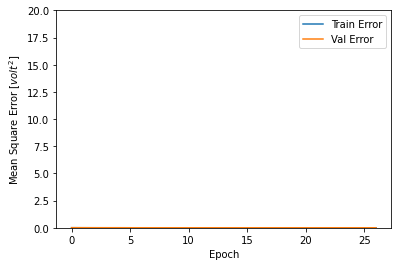

In [115]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [volt]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$volt^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).


....

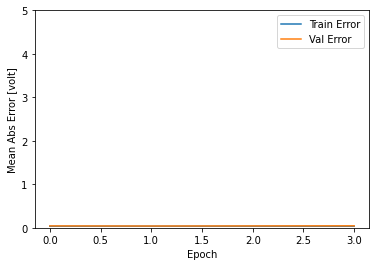

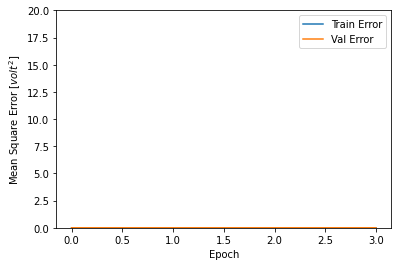

In [116]:
#model = build_model()


# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=2, verbose=0, mode='auto')

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [117]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} µl".format(mae))

Testing set Mean Abs Error:  0.05 µl


### Make predictions

Finally, predict volume values using data in the testing set:

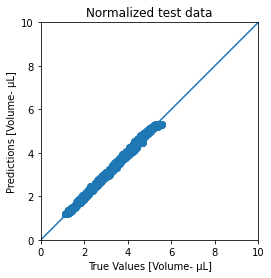

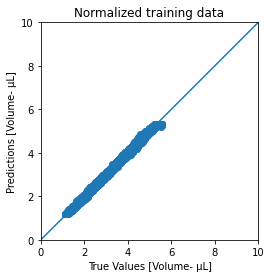

In [118]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.title('Normalized test data')
plt.xlabel('True Values [Volume- μL]')
plt.ylabel('Predictions [Volume- μL]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,10])
plt.ylim([0,10])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

test_predictions2 = model.predict(normed_train_data).flatten()

plt.scatter(train_labels, test_predictions2)
plt.title('Normalized training data')
plt.xlabel('True Values [Volume- μL]')
plt.ylabel('Predictions [Volume- μL]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,10])
plt.ylim([0,10])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


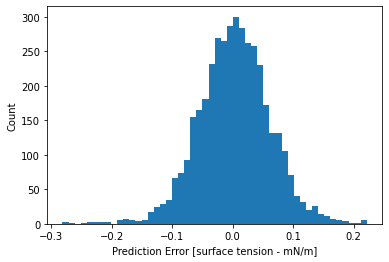

In [119]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [surface tension - mN/m]")
_ = plt.ylabel("Count")
plt.show()

# Saving the Model

When you are satisfied with the model and the accuracy continue from here:

Saving the model in a **SavedModel** format

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [120]:
# Save the entire model as a SavedModel.
filename=str('SDS_volume_pred_trial_5.h5')
!mkdir -p '/content/drive/My Drive/DropLev/MachineLearningModels' #Ceates a folder named "MachineLearningModels"
model.save('/content/drive/My Drive/DropLev/MachineLearningModels/'+filename)  #Saves the file

The SavedModel format is a directory containing a protobuf binary and a Tensorflow checkpoint. Inspect the saved model directory:

In [ ]:
# DropLev_volt_vol_prediction_model directory
#!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
#!ls saved_model/DropLev_volt_vol_prediction_model

Saving the model in a **HDF5** format

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
#model.save('DropLev_volt_vol_prediction_model.h5') 

# Reload a fresh Keras model from the saved model:

For **SavedModel** format

In [90]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/DropLev/MachineLearningModels/'+filename)

# Check its architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 20)                12020     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 12,041
Trainable params: 12,041
Non-trainable params: 0
_________________________________________________________________


For **HDF5** format

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('DropLev_volt_vol_prediction_model.h5')

# Show the model architecture
new_model.summary()

Evaluate the restored model (for both formats)

In [ ]:
# Evaluation
loss, mae, mse = new_model.evaluate(normed_test_data, test_labels, verbose=0)
print('Restored model, Mean absolute error: {:5.2f}'.format(mae))

print(new_model.predict(normed_test_data).shape)